In [35]:
import pickle
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use({'figure.figsize':(25,20)})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [3]:
# 导入数据
df = pd.read_csv('data/bilibili_rank100_data.csv')

In [4]:
# 数据预处理
df = df.drop_duplicates(subset=['title'],keep='last',inplace=False)
df = df.drop(df[df['time']>1000].index)
df[df.isnull().values==True]
df=df.reset_index(drop=True, inplace=False)
def LabelEncoding(df):
    x, dfc = 'partition', df
    key = dfc[x].unique()
    value = [i for i in range(len(key))]
    Dict = dict(zip(key, value))
    for i in range(len(key)):
        for j in range(dfc.shape[0]):
            if key[i] == dfc[x][j]:
                dfc[x][j] = Dict[key[i]]
    dfc[x] = dfc[x].astype(np.int64)
    return dfc

df = LabelEncoding(df)

In [5]:
df = df.drop(["author","title","tag"],axis = 1)

In [6]:
X = df.drop(["views"],axis = 1)
y = df["views"]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=6)

RandomizedSearchCV

随机搜索交叉验证，在给定参数范围内随机选择参数值进行指定次数的参数组合，找到效果最好的模型

交叉验证可以充分评估回归模型的准确性

In [8]:
# 决策树的个数
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# 最大特征数
max_features = ['auto', 'sqrt']
# 最大树深
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# 限制子树继续划分的条件
min_samples_split = [2, 5, 10]
# 叶子节点的最小样本数目
min_samples_leaf = [1, 2, 4]
# 构建树时是否使用bootstrap采样
bootstrap = [True, False]
 
# 创建随机网格
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
 
 
# 使用随机网格来搜索最佳超参数
# 实例化随机森林回归器
rf = RandomForestRegressor()
# 随机搜索参数，使用3折交叉验证。
# 在100种不同的组合中进行搜索，并使用所有可用的内核
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)
 
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [9]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

GridSearchCV

网格搜索交叉验证，网格搜索可以让模型参数按照我们给定的列表遍历，找到效果最好的模型

交叉验证可以充分评估回归模型的准确性

In [14]:
#构造参数字典，让这三个参数按照列表给定的顺序排列组合遍历一遍
param_grid = {
    'bootstrap': [True],
    'max_features': ['auto'],
    'n_estimators':[50,100,150,200],
    'max_depth':[45, 50, 55],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4],
}

#实例化随机森林回归器
rf = RandomForestRegressor()

#以随机森林回归器为基础构造网络搜索回归器
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [45, 50, 55],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

## 选取最优参数对应的模型

In [15]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 55,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 200}

In [16]:
rf_reg = grid_search.best_estimator_
rf_reg

RandomForestRegressor(max_depth=55, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=200)

## 特征重要度分析

In [18]:
rf_reg.feature_importances_

array([0.00045926, 0.00075589, 0.42368242, 0.09280487, 0.16178874,
       0.12027443, 0.0135178 , 0.11801474, 0.00980008, 0.05890176])

In [19]:
X.columns

Index(['partition', 'funs', 'like', 'coins', 'collect', 'share', 'danmu',
       'reply', 'time', 'like_rate'],
      dtype='object')

In [20]:
print('特征排序：')
feature_names = X.columns
feature_importances = rf_reg.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for index in indices:
    print('feature %s (%f)' %(feature_names[index],feature_importances[index]))

特征排序：
feature like (0.423682)
feature collect (0.161789)
feature share (0.120274)
feature reply (0.118015)
feature coins (0.092805)
feature like_rate (0.058902)
feature danmu (0.013518)
feature time (0.009800)
feature funs (0.000756)
feature partition (0.000459)


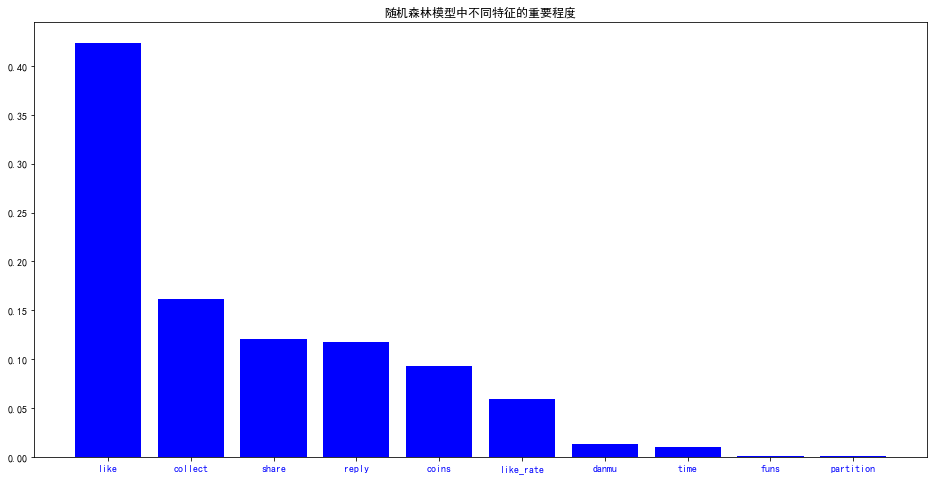

In [21]:
plt.figure(figsize=(16,8))
plt.title('随机森林模型中不同特征的重要程度')
plt.bar(range(len(feature_importances)),feature_importances[indices],color='b')
plt.xticks(range(len(feature_importances)),np.array(feature_names)[indices],color='b')
plt.show()

## 对训练集和测试集进行预测

In [30]:
train_preds = pd.DataFrame(rf_reg.predict(X_train))
test_preds = pd.DataFrame(rf_reg.predict(X_test))
train_preds.columns = ['views']
test_preds.columns = ['views']

## 计算MSE均方误差和RMSE均方根误差

In [33]:
print("\nModel Report")
print("MSE Train : %f" % metrics.mean_squared_error(y_train, train_preds))
print("MSE Test: %f" % metrics.mean_squared_error(y_test, test_preds))
print("RMSE Train: %f" % metrics.mean_squared_error(y_train, train_preds)**0.5)
print("RMSE Test: %f" % metrics.mean_squared_error(y_test, test_preds)**0.5)


Model Report
MSE Train : 703937668191.866577
MSE Test: 1377962755408.736816
RMSE Train: 839009.933309
RMSE Test: 1173866.583309


## 将模型打包成pkl文件

In [36]:
pickle.dump(rf_reg, open("rfFinal.pkl", "wb"))

In [ ]:
# train_preds.to_csv('RF_Train_Preds.csv', sep=',')
# test_preds.to_csv('RF_Test_Preds.csv', sep=',')